
# Analyzing Fairness and Bias in Crime Prediction Models

This tutorial investigates bias and fairness in predictive policing models. 
Using the Communities and Crime dataset, we explore the implications of using potentially imbalanced data and propose methods for improving fairness.
The main objectives are:

- Understand how bias manifests in the dataset and predictive models.
- Evaluate fairness metrics to measure the impact of these biases.
- Explore techniques to mitigate bias and assess their effectiveness.

Let's begin by exploring the dataset and understanding its structure.


In [1]:
! pip install ucimlrepo
! pip install matplotlib
! pip install scikit-learn
! pip install seaborn

In [2]:
from ucimlrepo import fetch_ucirepo 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer

#### **Load Dataset**

In [3]:
# fetch dataset 
communities_and_crime = fetch_ucirepo(id=183) 
  
# data (as pandas dataframes) 
X = communities_and_crime.data.features 
y = communities_and_crime.data.targets 
 
# metadata 
metadata = communities_and_crime.metadata
  
# variable information 
variables = communities_and_crime.variables

print(metadata)
print(variables)

{'uci_id': 183, 'name': 'Communities and Crime', 'repository_url': 'https://archive.ics.uci.edu/dataset/183/communities+and+crime', 'data_url': 'https://archive.ics.uci.edu/static/public/183/data.csv', 'abstract': 'Communities within the United States. The data combines socio-economic data from the 1990 US Census, law enforcement data from the 1990 US LEMAS survey, and crime data from the 1995 FBI UCR.', 'area': 'Social Science', 'tasks': ['Regression'], 'characteristics': ['Multivariate'], 'num_instances': 1994, 'num_features': 127, 'feature_types': ['Real'], 'demographics': ['Race', 'Age', 'Income', 'Occupation'], 'target_col': ['ViolentCrimesPerPop'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 2002, 'last_updated': 'Mon Mar 04 2024', 'dataset_doi': '10.24432/C53W3X', 'creators': ['Michael Redmond'], 'intro_paper': {'ID': 405, 'type': 'NATIVE', 'title': 'A data-driven software tool for enabling cooperative information s

In [4]:
# Convert to a dataframe
df = pd.concat([X, y], axis=1)

df.head()

,state,county,community,communityname,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,8,?,?,Lakewoodcity,1,0.19,0.33,0.02,0.90,0.12,...,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
1,53,?,?,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,...,0.02,0.12,0.45,?,?,?,?,0.00,?,0.67
2,24,?,?,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,...,0.01,0.21,0.02,?,?,?,?,0.00,?,0.43
3,34,5,81440,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,...,0.02,0.39,0.28,?,?,?,?,0.00,?,0.12
4,42,95,6096,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,...,0.04,0.09,0.02,?,?,?,?,0.00,?,0.03


In [5]:
# Replace '?' with NaN
df.replace('?', np.nan, inplace=True)

# Check for missing values again
print(df.isnull().sum())

state                     0
county                 1174
community              1177
communityname             0
fold                      0
                       ... 
LemasPctPolicOnPatr    1675
LemasGangUnitDeploy    1675
LemasPctOfficDrugUn       0
PolicBudgPerPop        1675
ViolentCrimesPerPop       0
Length: 128, dtype: int64


### **Data Preprocessing**

The `community` column represents unique identifiers for each community. Although the values are numeric, they should not be treated as continuous or ordinal variables. This is because the numeric values in the `community` column are simply community identifiers, meaning there is no magnitude relationship between them. If we treated the `community` column as a continuous or ordinal variable, the Random Forest model could interpret comparisons like 17 > 2 or 17 - 2 = 15, which doesn't make sense in this context. The model could mistakenly compare these communities based on numeric values, leading to incorrect conclusions. For this reason, we will remove it.

The `communityname` column contains the names of the communities. This column is a categorical variable represented as text, meaning it needs to be converted to a numeric form to be used in models like Random Forest, which require numeric data to perform splits and calculations. The model cannot process strings directly, so we need to either remove or encode this variable before feeding it into the model. Otherwise, the algorithm would not know how to handle this text column. For this reason, we will remove it.

The `state` column is numeric and contains codes that represent the states where the communities are located. These codes are not ordinal, meaning there is no inherent order between them (for example, code 1 does not mean it is more "important" or "larger" than code 2). Since `state` is a categorical numeric variable (with codes representing states), the most appropriate technique to handle it is One-Hot Encoding. This transformation converts each state code into a new binary column (0 or 1), where each row indicates the presence or absence of a specific state for each community. Although `state` is numeric, this technique is used to prevent the model from incorrectly interpreting numeric codes as ordinal. The model could, inappropriately, try to compare state codes as if they were continuous or ordinal variables (for example, 1 > 2). Thus, One-Hot Encoding resolves this by treating each state as an independent category.

Before removing the `community`, because it has Nan values, and `communityname` columns, we will store this information in dictionaries so that, if we need to refer to or use it in future analyses (such as interpreting the results), we can easily access it.
- The `community` dictionary maps each community code (which is a unique number) to the associated community name.
- The `state` dictionary maps each state code to a list of communities that belong to that state. In other words, the `state` dictionary will store which communities are located in which states, associating the state code with the corresponding communities.




In [6]:
# Filtrar as linhas onde `community` e `communityname` não são NaN
valid_data = df[['community', 'communityname']].dropna(subset=['community', 'communityname'])

# Criar o dicionário
community_mapping = dict(zip(valid_data['community'], valid_data['communityname']))
print(community_mapping)

{'81440': 'Willingborotownship', '6096': 'Bethlehemtownship', '41500': 'Lincolntown', '44105': 'Needhamtown', '30075': 'GrandChutetown', '91370': 'FortDodgecity', '1000': 'Alexandriacity', '17650': 'Denvilletownship', '66376': 'Rostravertownship', '93926': 'SiouxCitycity', '61798': 'Perrytownship', '22490': 'EastHamptontown', '47672': 'Lynchburgcity', '59280': 'Plainsborotownship', '40560': 'LittleEggHarbortownship', '22960': 'EastProvidencecity', '55950': 'Paramusborough', '81740': 'Winslowtownship', '12900': 'Claremontcity', '57660': 'Pennsaukentownship', '45120': 'Medfordtownship', '43620': 'Manvilleborough', '30570': 'Hawthorneborough', '75216': 'Stauntoncity', '42750': 'Mahwahtownship', '58200': 'PerthAmboycity', '54837': 'Oneidacity', '34950': 'Guilfordtown', '46520': 'Meridentown', '82525': 'Yarmouthtown', '84000': 'Yonkerscity', '63968': 'Polandtownship', '66700': 'Vermillioncity', '22240': 'EastGreenwichtown', '37875': 'Maldencity', '87560': 'Wolcotttown', '45140': 'Manchester

In [7]:
# Criar um dicionário que mapeia as comunidades para seus respectivos estados
# Filtra as linhas sem NaN nas colunas 'community' e 'state' e elimina duplicatas
community_to_state = df[['community', 'state']].dropna().drop_duplicates()

# Criar o dicionário de mapeamento
community_to_state_mapping = dict(zip(community_to_state['community'], community_to_state['state']))

# Exibir o dicionário resultante
print(community_to_state_mapping)

{'81440': 34, '6096': 42, '41500': 44, '44105': 25, '30075': 55, '91370': 19, '1000': 51, '17650': 34, '66376': 42, '93926': 19, '61798': 39, '22490': 9, '47672': 51, '59280': 34, '40560': 34, '22960': 44, '55950': 34, '81740': 34, '12900': 33, '57660': 34, '45120': 34, '43620': 34, '30570': 34, '75216': 51, '42750': 34, '58200': 34, '54837': 36, '34950': 9, '46520': 9, '82525': 25, '84000': 36, '63968': 39, '66700': 46, '22240': 44, '37875': 25, '87560': 9, '45140': 33, '76490': 34, '73060': 46, '83080': 42, '83432': 42, '20100': 25, '80240': 34, '47616': 42, '66060': 34, '21504': 39, '39300': 33, '58730': 39, '45056': 42, '22456': 39, '4825': 25, '13690': 34, '51660': 34, '79740': 25, '66660': 33, '75740': 34, '37000': 25, '62432': 42, '20080': 44, '56550': 34, '7310': 9, '7665': 25, '16495': 25, '70020': 34, '54040': 39, '74880': 42, '37490': 25, '82000': 51, '32296': 42, '36000': 34, '70380': 39, '5320': 34, '44700': 9, '53104': 42, '56966': 39, '18070': 34, '38715': 25, '48955': 2

In [8]:
# Drop features that are redundant or less relevant according to the domain knowledge
columns_to_drop = [
    'communityname', 
    'state', 
    'community', 
    'communityname',
    'numbUrban',  # Keep only 'pctUrban'
    'NumIlleg',  # Keep 'PctIlleg'
    'PctImmigRec10', 'PctImmigRec5', 'PctImmigRec8',  # Keep 'PctRecImmig5' and 'PctRecImmig10'
    'PctSpeakEnglOnly',  # Keep 'PctNotSpeakEnglWell' PctSpeakEnglOnly
]

# Drop the unnecessary columns
df = df.drop(columns=columns_to_drop, errors='ignore')

In [9]:
# Remover as colunas com valores ausentes
df = df.dropna(axis=1)

In [10]:
list(df.columns)

['fold',
 'population',
 'householdsize',
 'racepctblack',
 'racePctWhite',
 'racePctAsian',
 'racePctHisp',
 'agePct12t21',
 'agePct12t29',
 'agePct16t24',
 'agePct65up',
 'pctUrban',
 'medIncome',
 'pctWWage',
 'pctWFarmSelf',
 'pctWInvInc',
 'pctWSocSec',
 'pctWPubAsst',
 'pctWRetire',
 'medFamInc',
 'perCapInc',
 'whitePerCap',
 'blackPerCap',
 'indianPerCap',
 'AsianPerCap',
 'HispPerCap',
 'NumUnderPov',
 'PctPopUnderPov',
 'PctLess9thGrade',
 'PctNotHSGrad',
 'PctBSorMore',
 'PctUnemployed',
 'PctEmploy',
 'PctEmplManu',
 'PctEmplProfServ',
 'PctOccupManu',
 'PctOccupMgmtProf',
 'MalePctDivorce',
 'MalePctNevMarr',
 'FemalePctDiv',
 'TotalPctDiv',
 'PersPerFam',
 'PctFam2Par',
 'PctKids2Par',
 'PctYoungKids2Par',
 'PctTeen2Par',
 'PctWorkMomYoungKids',
 'PctWorkMom',
 'PctIlleg',
 'NumImmig',
 'PctImmigRecent',
 'PctRecentImmig',
 'PctRecImmig5',
 'PctRecImmig8',
 'PctRecImmig10',
 'PctNotSpeakEnglWell',
 'PctLargHouseFam',
 'PctLargHouseOccup',
 'PersPerOccupHous',
 'PersPerOwn

#### **Remove correlation features**
- **Reduction of redundancy:** Highly correlated variables carry similar information. So, keeping both can increase dimensionality without adding value.

- **Improved interpretability:** Fewer features make the model easier to understand.

- **Avoiding overfitting:** High dimensionality and redundancy increase the risk of overfitting, especially with small datasets.

- **Reduced complexity:** Random Forest uses decision trees, which can become more complex with correlated variables.

- **Performance improvement:** By reducing redundancy, the model can converge more quickly and efficiently, improving accuracy.

- **Bias and fairness:** By removing variables related to sensitive attributes, we can mitigate potential biases in the model.

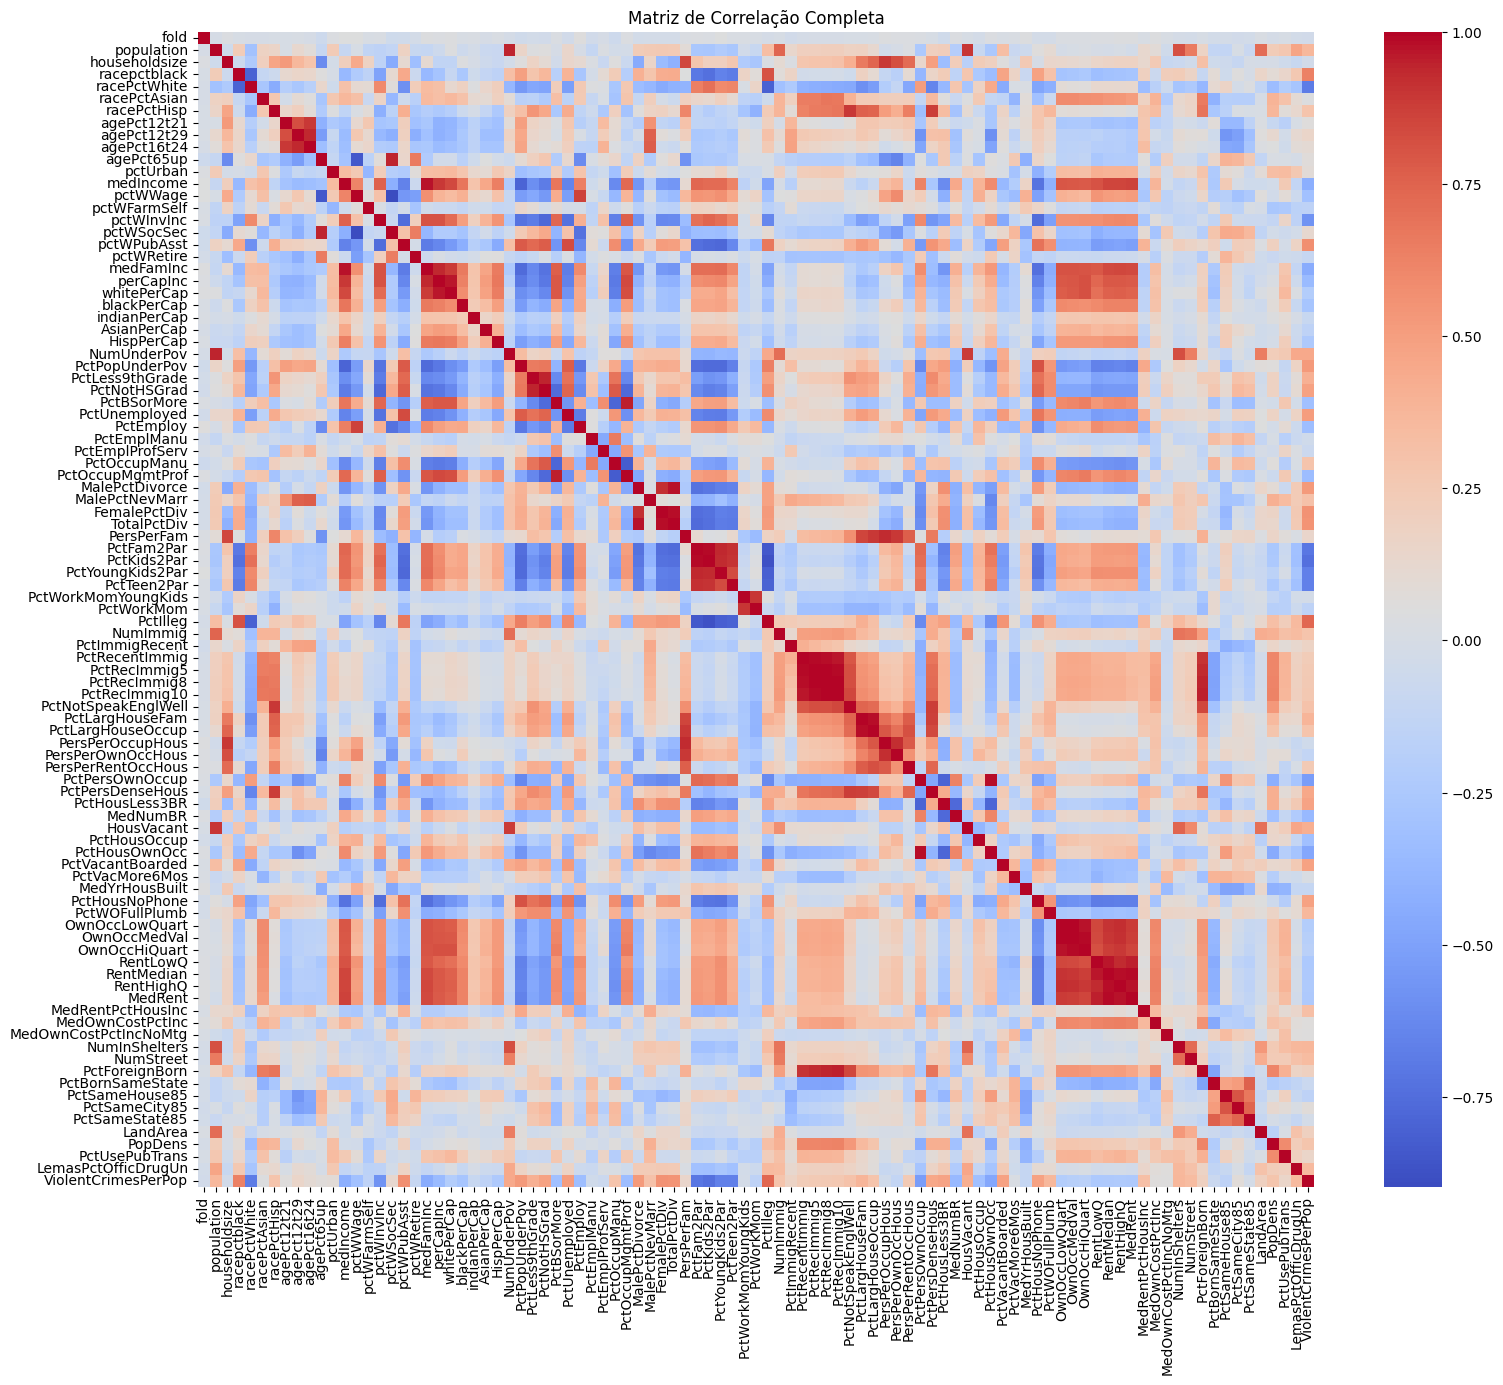

In [11]:
correlation_matrix = df.corr()

# 2. Visualizar a matriz completa
plt.figure(figsize=(18, 15))
# Plotar o heatmap com rótulos no eixo
sns.heatmap(
    correlation_matrix,
    annot=False,  # Não exibir valores diretamente
    cmap="coolwarm",
    fmt=".2f",
    cbar=True,
    xticklabels=correlation_matrix.columns,  # Garantir os rótulos no eixo x
    yticklabels=correlation_matrix.columns   # Garantir os rótulos no eixo y
)
plt.title("Matriz de Correlação Completa")
plt.show()

In [12]:
upper_triangle = correlation_matrix.where(
    np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)
)

In [13]:
# Find and display columns to drop alongside the column they are highly correlated with
highly_correlated_pairs = []

for column in upper_triangle.columns:
    correlated_with = upper_triangle.index[upper_triangle[column] > 0.95].tolist()
    if correlated_with:
        for correlated_col in correlated_with:
            highly_correlated_pairs.append((correlated_col, column))  # Keep correlated_col, drop column

# Print the pairs (kept column, dropped column)
for keep, drop in highly_correlated_pairs:
    print(f"Keeping: {keep}, Dropping: {drop}")

Keeping: medIncome, Dropping: medFamInc
Keeping: perCapInc, Dropping: whitePerCap
Keeping: PctBSorMore, Dropping: PctOccupMgmtProf
Keeping: MalePctDivorce, Dropping: TotalPctDiv
Keeping: FemalePctDiv, Dropping: TotalPctDiv
Keeping: PctFam2Par, Dropping: PctKids2Par
Keeping: PctRecentImmig, Dropping: PctRecImmig5
Keeping: PctRecentImmig, Dropping: PctRecImmig8
Keeping: PctRecImmig5, Dropping: PctRecImmig8
Keeping: PctRecentImmig, Dropping: PctRecImmig10
Keeping: PctRecImmig5, Dropping: PctRecImmig10
Keeping: PctRecImmig8, Dropping: PctRecImmig10
Keeping: PctLargHouseFam, Dropping: PctLargHouseOccup
Keeping: PctPersOwnOccup, Dropping: PctHousOwnOcc
Keeping: OwnOccLowQuart, Dropping: OwnOccMedVal
Keeping: OwnOccLowQuart, Dropping: OwnOccHiQuart
Keeping: OwnOccMedVal, Dropping: OwnOccHiQuart
Keeping: RentLowQ, Dropping: RentMedian
Keeping: RentMedian, Dropping: RentHighQ
Keeping: RentMedian, Dropping: MedRent
Keeping: RentHighQ, Dropping: MedRent
Keeping: PctRecImmig10, Dropping: PctForeig

In [14]:
to_drop = list(set([pair[1] for pair in highly_correlated_pairs]))
to_drop = [feature for feature in to_drop if feature != 'WhitePerCap']

# Imprimir a lista final de colunas a serem removidas
print(f"Total de features a serem removidas: {len(to_drop)}")

Total de features a serem removidas: 16


In [15]:
# Criar um novo DataFrame removendo as features identificadas
df = df.drop(columns=to_drop, errors='ignore')

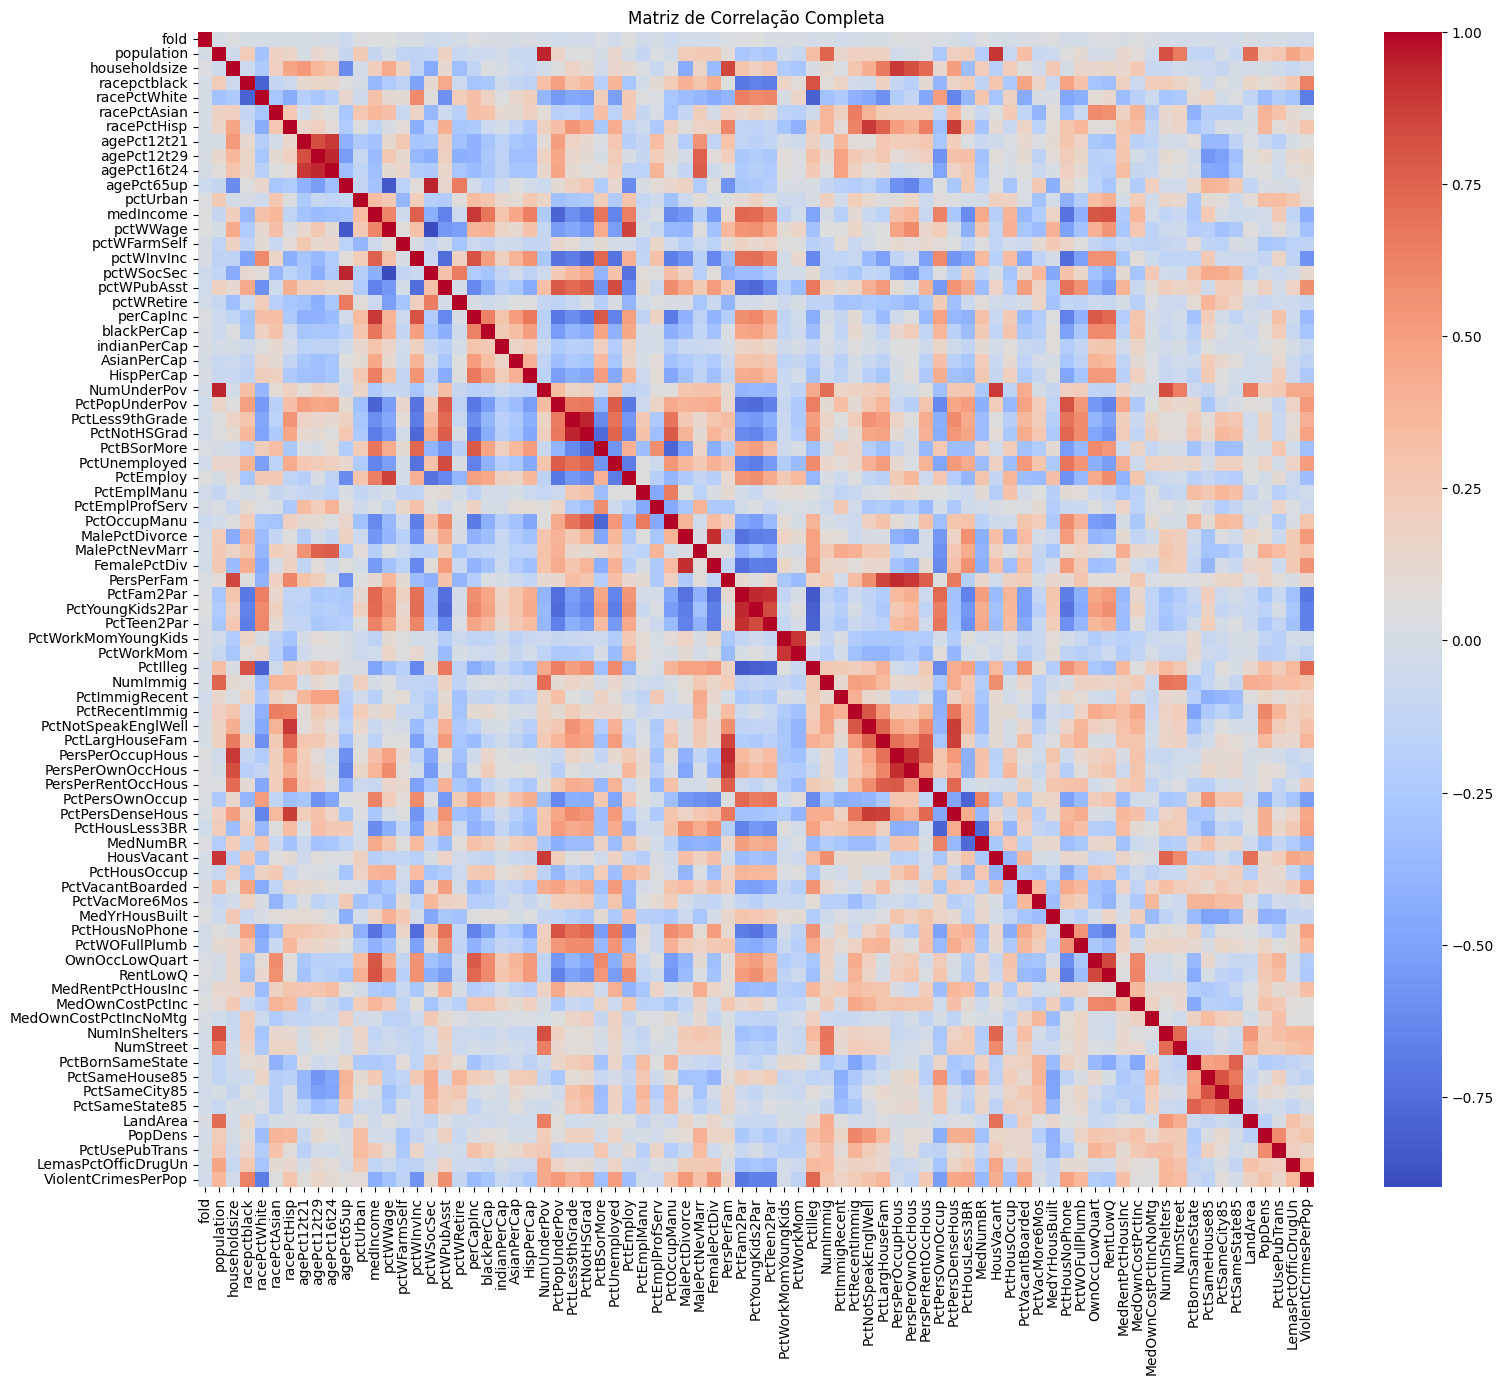

In [16]:
correlation_matrix = df.corr()

# 2. Visualizar a matriz completa
plt.figure(figsize=(18, 15))
# Plotar o heatmap com rótulos no eixo
sns.heatmap(
    correlation_matrix,
    annot=False,  # Não exibir valores diretamente
    cmap="coolwarm",
    fmt=".2f",
    cbar=True,
    xticklabels=correlation_matrix.columns,  # Garantir os rótulos no eixo x
    yticklabels=correlation_matrix.columns   # Garantir os rótulos no eixo y
)
plt.title("Matriz de Correlação Completa")
plt.show()

In [17]:
df

,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,...,NumStreet,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LandArea,PopDens,PctUsePubTrans,LemasPctOfficDrugUn,ViolentCrimesPerPop
0,1,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,...,0.00,0.42,0.50,0.51,0.64,0.12,0.26,0.20,0.32,0.20
1,1,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,...,0.00,0.50,0.34,0.60,0.52,0.02,0.12,0.45,0.00,0.67
2,1,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,0.28,...,0.00,0.49,0.54,0.67,0.56,0.01,0.21,0.02,0.00,0.43
3,1,0.04,0.77,1.00,0.08,0.12,0.10,0.51,0.50,0.34,...,0.00,0.30,0.73,0.64,0.65,0.02,0.39,0.28,0.00,0.12
4,1,0.01,0.55,0.02,0.95,0.09,0.05,0.38,0.38,0.23,...,0.00,0.72,0.64,0.61,0.53,0.04,0.09,0.02,0.00,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,10,0.01,0.40,0.10,0.87,0.12,0.16,0.43,0.51,0.35,...,0.00,0.28,0.34,0.48,0.39,0.01,0.28,0.05,0.00,0.09
1990,10,0.05,0.96,0.46,0.28,0.83,0.32,0.69,0.86,0.73,...,0.00,0.25,0.17,0.10,0.00,0.02,0.37,0.20,0.00,0.45
1991,10,0.16,0.37,0.25,0.69,0.04,0.25,0.35,0.50,0.31,...,0.02,0.68,0.61,0.79,0.76,0.08,0.32,0.18,0.91,0.23
1992,10,0.08,0.51,0.06,0.87,0.22,0.10,0.58,0.74,0.63,...,0.01,0.64,0.54,0.59,0.52,0.03,0.38,0.33,0.22,0.19


#### **Model Predict**

In [18]:
X = df.drop('ViolentCrimesPerPop', axis=1)
y = df['ViolentCrimesPerPop']

In [19]:
# Split data
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Definir o modelo
model = RandomForestRegressor(random_state=42)
model.fit(X, y)

# Usar cross_val_score para calcular o MSE
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)  # Negativo porque queremos minimizar o erro
cv_scores = cross_val_score(model, X, y, cv=10, scoring=mse_scorer)

# Usar cross_val_score para calcular o MAE
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)  # Negativo porque queremos minimizar o erro
cv_scores_mae = cross_val_score(model, X, y, cv=10, scoring=mae_scorer)

# Calcular o MSE médio
mean_mse = -cv_scores.mean()  # Tornar positivo novamente

# Calcular o MAE médio
mean_mae = -cv_scores_mae.mean()  # Tornar positivo novamente

# Exibir os resultados
print("MSE por fold:", -cv_scores)  # MSE de cada fold
print("MSE médio:", mean_mse)

print("MAE por fold:", -cv_scores_mae)  # MAE de cada fold
print("MAE médio:", mean_mae)

KeyboardInterrupt: 

In [ ]:
df['PctPopUnderPov'].unique()

array([0.19, 0.24, 0.27, 0.1 , 0.06, 0.12, 0.11, 0.64, 0.45, 0.18, 0.07,
       0.33, 0.48, 0.04, 0.22, 0.28, 0.34, 0.58, 0.36, 0.63, 0.3 , 0.25,
       0.32, 0.57, 0.01, 1.  , 0.43, 0.38, 0.59, 0.02, 0.17, 0.54, 0.44,
       0.31, 0.13, 0.05, 0.61, 0.16, 0.08, 0.5 , 0.46, 0.09, 0.37, 0.4 ,
       0.39, 0.75, 0.52, 0.82, 0.2 , 0.49, 0.03, 0.23, 0.42, 0.99, 0.73,
       0.53, 0.15, 0.85, 0.14, 0.26, 0.47, 0.7 , 0.66, 0.41, 0.9 , 0.6 ,
       0.76, 0.55, 0.68, 0.67, 0.56, 0.71, 0.35, 0.21, 0.72, 0.51, 0.  ,
       0.69, 0.83, 0.79, 0.93, 0.29, 0.62, 0.78, 0.65, 0.74, 0.8 , 0.89,
       0.88, 0.91, 0.84, 0.81, 0.95, 0.86, 0.77, 0.98, 0.96, 0.97, 0.92,
       0.94])

`MSE (Mean Squared Error):`Measures the mean squared difference between the actual and predicted values. A lower value indicates that the model is closer to ideal predictions.

`MAE (Mean Absolute Error):`Measures the average of the absolute differences between the actual and predicted values. It also indicates how close the predictions are to the actual values but does not penalize large errors as strongly as the MSE.

The extremely low MSE and MAE values suggest that the model is performing very well, with high prediction accuracy. 
This may indicate that the data has been well-processed and that the `RandomForestRegressor` model is appropriate for the task.

It is important to note that the significance of the error values depends on the scale of the target data. Since the target variable (`ViolentCrimesPerPop`) has very small values (close to 0), small errors like those reported are expected.

### **Demographic Analysis**

In [ ]:
# 1. Calcular a matriz de correlação
correlation_matrix = df.corr()

# 2. Selecionar as variáveis sensíveis e o target
sensitive_and_target = ['racepctblack', 'racePctHisp', 'racePctWhite', 'racePctAsian', 'ViolentCrimesPerPop']

# Filtrar apenas as correlações relevantes
filtered_correlation_matrix = correlation_matrix.loc[sensitive_and_target, sensitive_and_target]

# 3. Visualizar a matriz de correlação
plt.figure(figsize=(8, 6))
sns.heatmap(filtered_correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de Correlação - Variáveis Sensíveis e Target")
plt.show()

KeyError: "['racepctblack', 'racePctHisp', 'racePctWhite'] not in index"

#### Correlation Matrix Analysis

The presented correlation matrix evaluates the relationship between sensitive variables (percentages of different racial groups) and the target variable, ViolentCrimesPerPop (violent crimes per 100,000 inhabitants). Each cell of the matrix shows the Pearson correlation coefficient, which ranges from -1 to 1.

1. **racepctblack and ViolentCrimesPerPop:**
   Significant positive correlation (0.63): As the percentage of the African American population increases, the number of violent crimes tends to increase. This type of correlation could indicate systemic bias and may reflect structural factors (such as social and economic inequalities) rather than a causal relationship.

2. **racePctHisp and ViolentCrimesPerPop:**
   Moderate positive correlation (0.29): Higher percentages of Hispanic populations are slightly associated with increases in violent crimes.

3. **racePctWhite and ViolentCrimesPerPop:**
   Significant negative correlation (-0.68): As the percentage of the Caucasian population increases, the violent crime rate tends to decrease.

4. **racePctAsian and ViolentCrimesPerPop:**
   Very low correlation (0.04): The percentage of the Asian population seems to have little to no relevant relationship with the number of violent crimes.

Exploring target and group feature distributions...



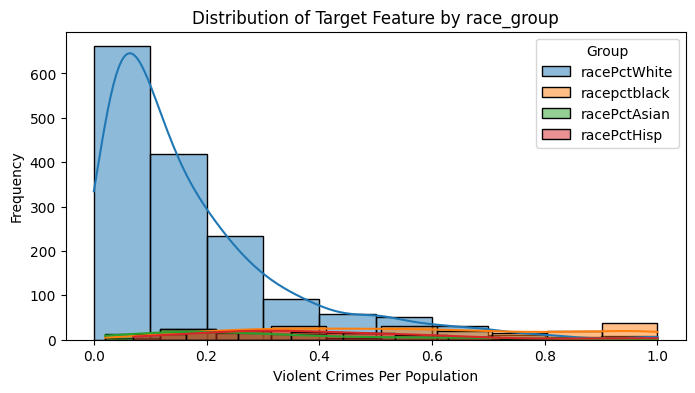

Exploring race-related features distributions...



In [ ]:
race_columns = ['racepctblack',
 'racePctWhite',
 'racePctAsian',
 'racePctHisp',
]

# Define target and group feature
target_feature = 'ViolentCrimesPerPop'  # Replace with actual target column name
group_feature = 'race_group'  # Replace with actual group column, if exists

# Criar o race_group com base nas colunas de raça
def assign_race_group(row, race_columns):
    max_race = row[race_columns].idxmax()  # Encontrar a coluna com o maior valor percentual
    return max_race

df['race_group'] = df.apply(lambda row: assign_race_group(row, race_columns), axis=1)

# Visualizar a distribuição da variável-alvo
def plot_class_distribution(data, target_feature, group_feature=None, bins=10):
    plt.figure(figsize=(8, 4))
    
    if group_feature:
        # Histograma da variável-alvo para diferentes grupos
        for group in data[group_feature].unique():
            sns.histplot(
                data[data[group_feature] == group][target_feature],
                bins=bins, label=f"{group}", kde=True, alpha=0.5
            )
        plt.legend(title="Group")
    else:
        # Histograma geral da variável-alvo
        sns.histplot(data[target_feature], bins=bins, kde=True, color="skyblue", alpha=0.7)

    plt.title("Distribution of Target Feature" + (f" by {group_feature}" if group_feature else ""))
    plt.xlabel("Violent Crimes Per Population")
    plt.ylabel("Frequency")
    plt.show()


# Função para explorar os dados combinados
def explore_data(data, target_feature, group_feature, race_columns):
    print("Exploring target and group feature distributions...\n")
    plot_class_distribution(data, target_feature, group_feature)
    
    print("Exploring race-related features distributions...\n")

# Chamar a função
explore_data(df, target_feature, group_feature, race_columns)


The first graph shows the distribution of the variable **ViolentCrimesPerPop**, which represents the proportion of violent crimes relative to the population. Most observations are concentrated within the range of 0.0 to 0.2 for **ViolentCrimesPerPop**, indicating that the majority of areas in the dataset experience low violent crime rates. The frequency declines sharply as the crime rate increases. For instance, very few areas have **ViolentCrimesPerPop** values exceeding 0.6. Extremely high crime rates, nearing 1.0, are rare, suggesting that such cases are outliers or uncommon.

The data is segmented by racial or demographic groups (e.g., racePctWhite, racepctblack, racePctAsian, etc.), each represented by different colors in the graph.
#### **Dominance of racePctWhite**
The distribution for `racePctWhite` (shown in blue) dominates the graph, both in terms of frequency and range. This suggests that areas with a high proportion of white populations make up the majority of observations in the dataset. These areas predominantly fall within the lower ranges of ViolentCrimesPerPop (0.0–0.2), reinforcing the idea that these areas are associated with lower crime rates.

#### **Other Groups (racepctblack, racePctAsian, etc.)**
Other groups, such as `racepctblack`, `racePctAsian`, `racePctHisp`, and `blackPerCap`, exhibit significantly lower frequencies across all ranges of ViolentCrimesPerPop. This suggests that:
- These groups are underrepresented in the dataset, or
- Areas with higher concentrations of these groups are fewer in number or cover smaller populations.
The curves for these groups are flatter, indicating that their observations are more dispersed across the crime rate spectrum compared to the dominant racePctWhite group.


The dominance of `racePctWhite` in the low-crime range **may bias the model's learning process**. Specifically:
- The model may become overly tuned to areas dominated by white populations, leading to systematic underperformance for areas associated with underrepresented groups.
- The dataset's imbalance could result in biased predictions if these discrepancies are not addressed.

#### **Analysis of the Two Graphs**

The two graphs provide complementary insights into the relationships between the sensitive race-related variables and the target, **ViolentCrimesPerPop**.

#### Graph 1: Correlation Matrix  
**Observations:**  
- **racepctblack** has a strong positive correlation with the target (0.63), which supports the higher frequency of violent crime values seen in Graph 2.  
- **racePctWhite** has a strong negative correlation with the target (-0.68), consistent with the concentration of lower violent crime values in this group.  
- **racePctHisp** shows a moderate positive correlation with the target (0.29), reflecting a less pronounced but still noticeable relationship, as seen in Graph 2.  
- **racePctAsian** has an almost negligible correlation with the target (0.04), which aligns with the distribution in Graph 2, where no clear pattern is evident.  

#### Graph 2: Target Distribution by Racial Groups  
This graph illustrates the distribution of the target (**ViolentCrimesPerPop**) segmented by different racial groups (% of population).  
**Observations:**  
- The **racePctWhite** group shows a concentration of low target values, indicating a lower prevalence of violent crimes in communities with a higher proportion of Caucasian individuals.  
- The **racepctblack** group exhibits a higher frequency of larger target values, indicating an association with a greater prevalence of violent crimes.  
- The **racePctHisp** and **racePctAsian** groups display more neutral distributions, with less association to extreme target values.  

### Relationship Between the Two Graphs  
**Visual and Statistical Confirmation:**  
Graph 2 shows visual trends that are supported by the correlations observed in Graph 1. For example:  
- The higher frequency of violent crimes in communities with a larger **racepctblack** population is supported by the positive correlation (0.63).  
- The tendency for lower violent crime rates in communities with a higher **racePctWhite** population is confirmed by the negative correlation (-0.68).  


In [ ]:
df

,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,...,state_47,state_48,state_49,state_50,state_51,state_53,state_54,state_55,state_56,race_group
0,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,0.32,...,0,0,0,0,0,0,0,0,0,racePctWhite
1,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,0.27,...,0,0,0,0,0,1,0,0,0,racePctWhite
2,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,0.28,0.32,...,0,0,0,0,0,0,0,0,0,racePctWhite
3,0.04,0.77,1.00,0.08,0.12,0.10,0.51,0.50,0.34,0.21,...,0,0,0,0,0,0,0,0,0,racepctblack
4,0.01,0.55,0.02,0.95,0.09,0.05,0.38,0.38,0.23,0.36,...,0,0,0,0,0,0,0,0,0,racePctWhite
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,0.01,0.40,0.10,0.87,0.12,0.16,0.43,0.51,0.35,0.30,...,0,0,0,0,0,0,0,0,0,racePctWhite
1990,0.05,0.96,0.46,0.28,0.83,0.32,0.69,0.86,0.73,0.14,...,0,0,0,0,0,0,0,0,0,racePctAsian
1991,0.16,0.37,0.25,0.69,0.04,0.25,0.35,0.50,0.31,0.54,...,0,0,0,0,0,0,0,0,0,racePctWhite
1992,0.08,0.51,0.06,0.87,0.22,0.10,0.58,0.74,0.63,0.41,...,0,0,0,0,0,0,0,0,0,racePctWhite


## Fairness Metrics

In this analysis, we will use the following fairness metrics:

1. **Demographic Parity**: Ensures that positive predictions are equally likely across all groups.
2. **Equalized Odds**: Ensures equal true positive and false positive rates across groups.

By measuring these metrics, we can evaluate the presence of bias in our predictive models and compare mitigation techniques.


In [ ]:
y_pred = model.predict(X)
""" y = df['ViolentCrimesPerPop'] """

print(len(y_pred))
print(len(y))

1994
1994


In [ ]:
# Calculate errors by group
def fairness_metrics(y_true, y_pred, group):
    results = {}
    
    for g in group.unique():
        mask = group == g
        errors = y_true[mask] - y_pred[mask]  # Residuals
        
        # Metrics
        results[g] = {
            "Mean Absolute Error": np.mean(np.abs(errors)),
            "Mean Squared Error": np.mean(errors**2),
            "Mean Prediction": np.mean(y_pred[mask]),
            "Mean True Value": np.mean(y_true[mask]),
            "Mean Residual": np.mean(errors),
        }
    
    return pd.DataFrame(results).T

# Assuming y_true and y_pred are continuous and group is a categorical variable
fairness_df = fairness_metrics(y, y_pred, df[group_feature])

# Print results
print(fairness_df)

              Mean Absolute Error  Mean Squared Error  Mean Prediction  \
racePctWhite             0.028883            0.001866         0.177390   
racepctblack             0.064873            0.006621         0.567433   
racePctAsian             0.037514            0.002485         0.315525   
racePctHisp              0.045414            0.003476         0.418428   

              Mean True Value  Mean Residual  
racePctWhite         0.174701      -0.002689  
racepctblack         0.567078      -0.000356  
racePctAsian         0.317386       0.001861  
racePctHisp          0.415478      -0.002950  


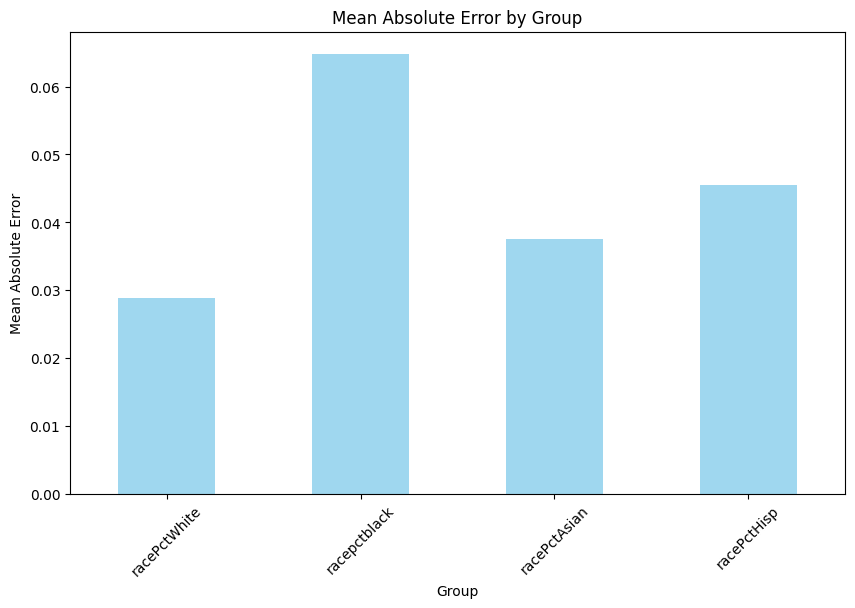

In [ ]:
plt.figure(figsize=(10, 6))
fairness_df["Mean Absolute Error"].plot(kind="bar", alpha=0.8, color="skyblue")
plt.title("Mean Absolute Error by Group")
plt.ylabel("Mean Absolute Error")
plt.xlabel("Group")
plt.xticks(rotation=45)
plt.show()

#### Mean Absolute Error by Group

- Groups with higher MAE have less accurate predictions. => **racepctblack**

- Investigate why some groups might have higher MAE => reasons: data imbalance, feature correlations, or bias in the dataset

<Figure size 1000x600 with 0 Axes>

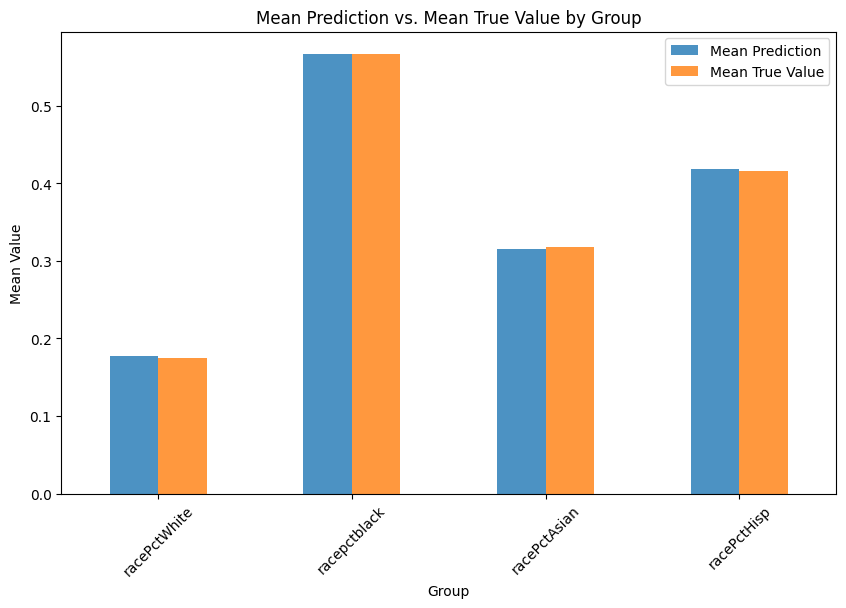

In [ ]:
plt.figure(figsize=(10, 6))
fairness_df[["Mean Prediction", "Mean True Value"]].plot(kind="bar", alpha=0.8, figsize=(10, 6))
plt.title("Mean Prediction vs. Mean True Value by Group")
plt.ylabel("Mean Value")
plt.xlabel("Group")
plt.legend(["Mean Prediction", "Mean True Value"])
plt.xticks(rotation=45)
plt.show()

#### Mean Prediction vs. Mean True Value by Group

- Groups where the mean prediction aligns closely with the mean true value have less bias.

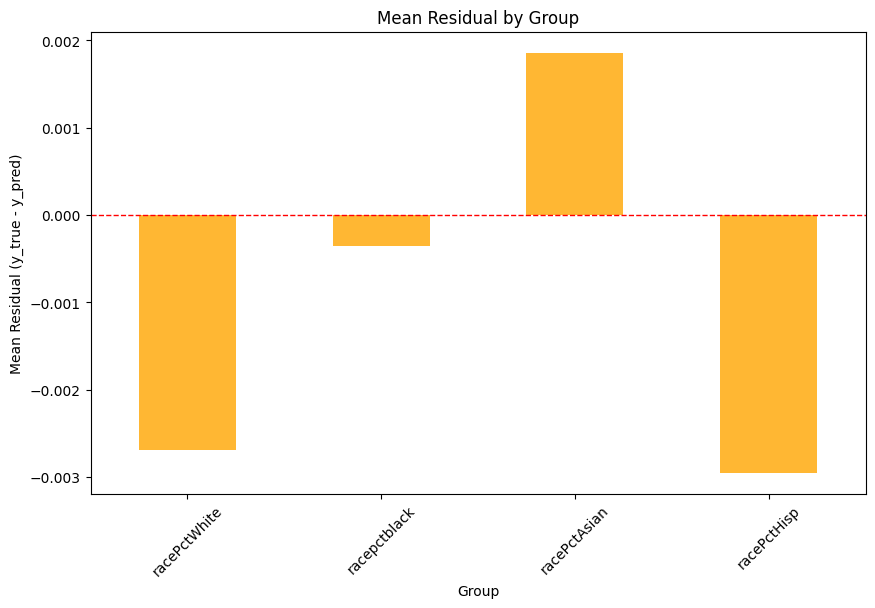

In [ ]:
plt.figure(figsize=(10, 6))
fairness_df["Mean Residual"].plot(kind="bar", color="orange", alpha=0.8)
plt.title("Mean Residual by Group")
plt.ylabel("Mean Residual (y_true - y_pred)")
plt.xlabel("Group")
plt.axhline(0, color="red", linestyle="--", linewidth=1)  # Reference line for zero residual
plt.xticks(rotation=45)
plt.show()

#### Mean Residual by Group

- Positive residuals indicate the model underpredicts the true value for that group.
- Negative residuals indicate the model overpredicts the true value for that group.

- Large residuals (positive or negative) indicate significant prediction errors.

#### Fairness Implications

- A racial group with consistently underpredicted crime rates might be underserved by public policies or interventions. => **racePctAsian**
- A racial group with consistently overpredicted crime rates might be unfairly targeted => Overpolicing generates more crimes reports => **racePctWhite** 
- Predictions align closely with reality, indicating fairness for this group. => **racepctblack**

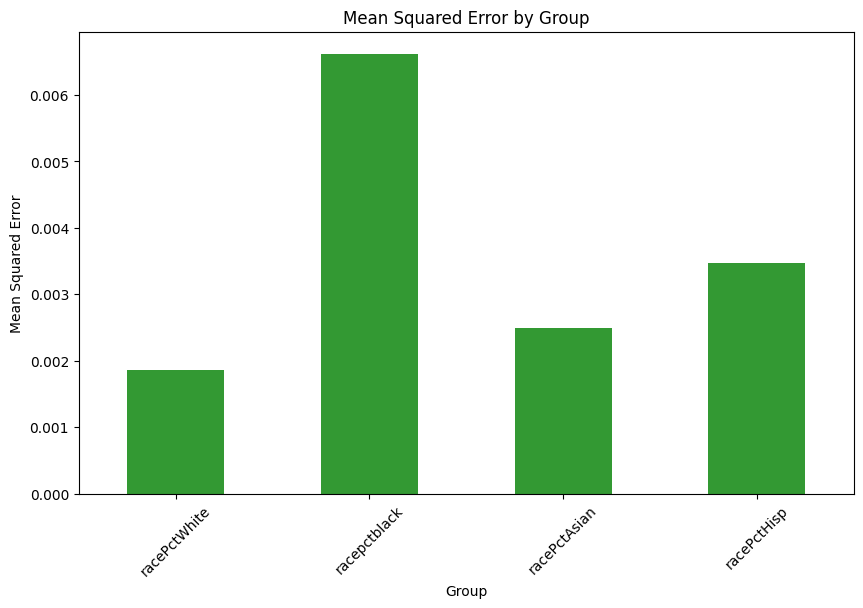

In [ ]:
plt.figure(figsize=(10, 6))
fairness_df["Mean Squared Error"].plot(kind="bar", alpha=0.8, color="green")
plt.title("Mean Squared Error by Group")
plt.ylabel("Mean Squared Error")
plt.xlabel("Group")
plt.xticks(rotation=45)
plt.show()

#### Mean Squared Error by Group

- Groups with higher MSE suffer from more severe prediction inaccuracies.
- Investigate the data distribution and representation for groups with high MSE.

#### Confusion Matrices per Group

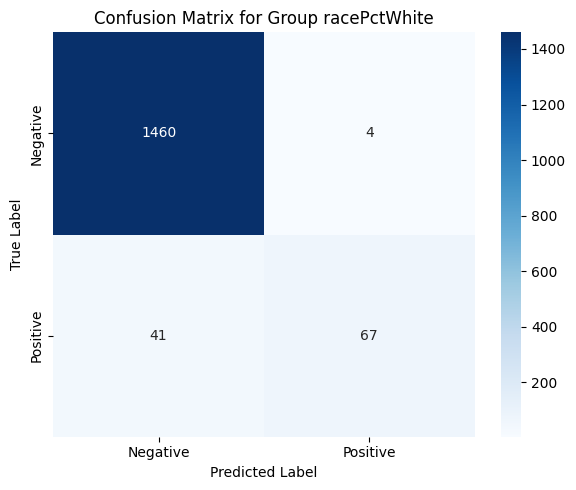

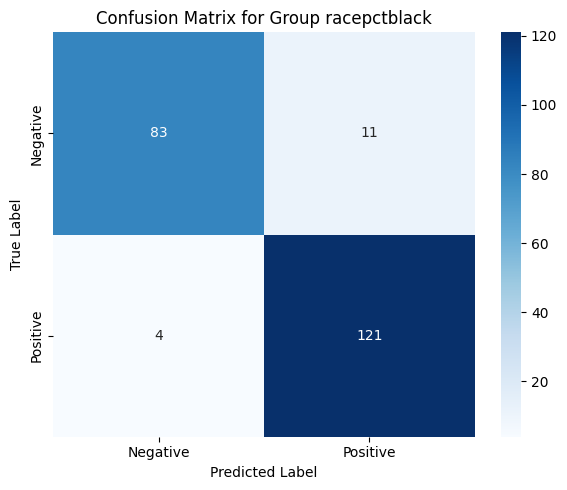

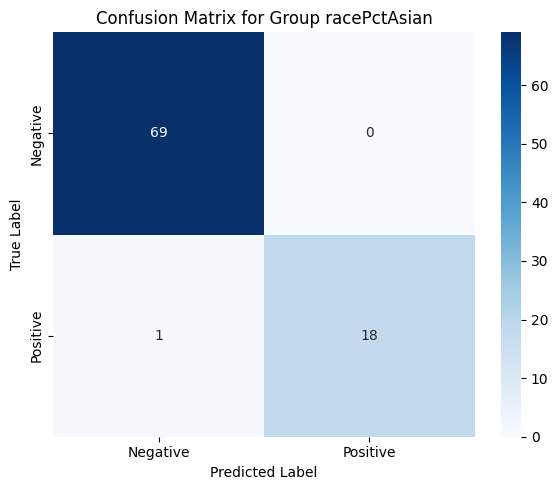

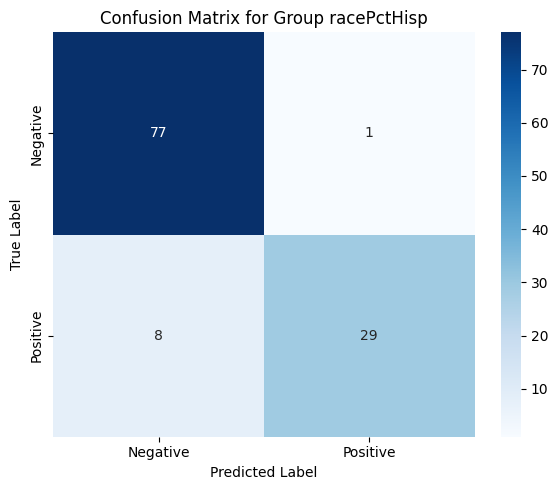

In [ ]:
from sklearn.metrics import confusion_matrix
def groupwise_confusion_matrix(y_true, y_pred, group, threshold=0.5):
    # Discretize predictions and true values based on threshold
    y_true_binary = (y_true >= threshold).astype(int)
    y_pred_binary = (y_pred >= threshold).astype(int)
    
    # Dictionary to store confusion matrices for each group
    confusion_matrices = {}

    # Compute confusion matrix for each unique group
    for g in group.unique():
        mask = group == g  # Filter data for the group
        cm = confusion_matrix(y_true_binary[mask], y_pred_binary[mask], labels=[0, 1])
        confusion_matrices[g] = {
            "Confusion Matrix": cm,
            "TN": cm[0, 0],
            "FP": cm[0, 1],
            "FN": cm[1, 0],
            "TP": cm[1, 1],
        }
    
    return confusion_matrices

def plot_confusion_matrices(confusion_matrices):
    for group, cm_data in confusion_matrices.items():
        cm = cm_data["Confusion Matrix"]

        # Plot heatmap
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=["Negative", "Positive"],
                    yticklabels=["Negative", "Positive"])
        plt.title(f"Confusion Matrix for Group {group}")
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.tight_layout()
        plt.show()

# Example usage
groupwise_cm = groupwise_confusion_matrix(y, y_pred, df['race_group'])

# Call the function with your computed confusion matrices
plot_confusion_matrices(groupwise_cm)

#### Confusion Matrices

- Groups with high false positive rates may face unfair penalization. => DOESN'T HAPPEN!!

- Groups with high false negative rates may face underrepresentation (Representation below of what is necessary). => **racePctWhite** has a higher false negative rates compared to the other groups

- Equal true positive rates (TPR) and false positive rates (FPR) across groups suggest fairness in classification. => DOESN'T HAPPEN!! => **racePctWhite** has higher TPR than others and **racepctblack** has higher FPR than others

- High TPR for a Group (**racepctblack**) : The model is highly sensitive to positive cases for this group, capturing most of them; However, this might lead to over-prediction.

- High FPR for a Group (**racePctWhite**) : The model incorrectly flags many negatives as positives for this group; This can lead to over-policing, unnecessary interventions, or false accusations for that group.